- [imports](#imports)
- [settings](#settings)
- [data](#data)
- [methodology](#methodology)
- [results](#results)
    - [probability](#prob)
    - [variance](#mfiv)
- [appendix](#appendix)
    - [walkthrough](#walkthrough)

# imports

In [1]:
# pip/conda
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings  # suppress warnings

# project
from config import *
from src.datafeed.downstream import *
from src.visuals import *

# settings

In [2]:
# parameters
TAU = 1/12  # maturity of options

# matplotlib
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']

# formatting frames
def format_dataframe(df_: pd.DataFrame, tail=True):
    """A little formatter helper."""
    if tail:
        return format_dataframe(df_.tail(), tail=False)
    
    if df_.index.inferred_type == 'datetime64':
        return format_dataframe(df_.rename_axis(index="date").reset_index(),
                                tail=tail)
    
    res_ = df_\
        .style.format(formatter={"date": lambda x: x.strftime("%Y-%m-%d %H:%M")},
                      precision=2)\
        .hide(axis=0)
    return res_

# suppress warnings
warnings.filterwarnings('ignore')

# data

## events

Events and their timestamps (GMT+1) are from Bloomberg.

In [3]:
# load events data
d_events = get_timeline()
dt_t = d_events.index[0]

format_dataframe(d_events, tail=False)

date,event
2022-02-24 04:06,putin announces special military operation
2022-02-18 22:58,biden warns russia is planning attack in coming days
2022-02-17 15:19,biden estimates prob of invasion as very high
2022-02-11 20:03,jake sullivan believes putin has decided to invade next week
2022-02-11 11:34,blinken warns russia can attack during the olympics


## spot
Spot quotes of USDRUB at 1-min frequency (GMT+1 time) are from Bloomberg.

In [4]:
# load spot data
d_spot = get_spot_data()

format_dataframe(d_spot.set_index("date"), tail=True)

date,spot
2022-02-28 16:46,109.50
2022-02-28 16:47,109.61
2022-02-28 16:48,109.54
2022-02-28 16:49,107.90
2022-02-28 16:50,107.82


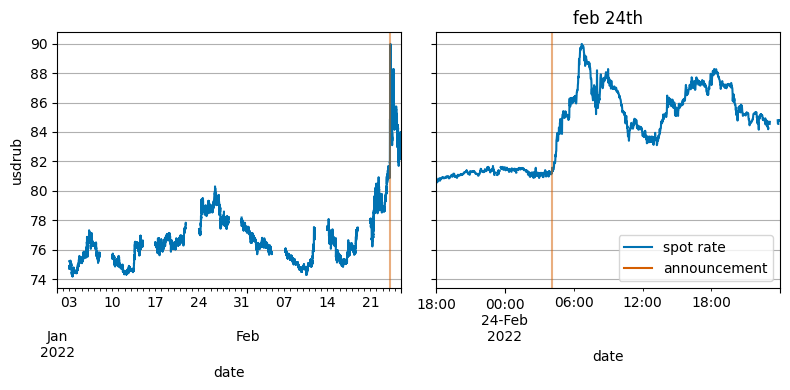

In [5]:
# plot spot exchange rate dynamics
plot_spot(d_spot.set_index("date").squeeze())
plt.show()

## forward
1-month forward quotes are from Bloomberg:

In [6]:
# load forward data
d_forward = get_forward_data()

format_dataframe(d_forward, tail=True)

date,forward
2022-02-28 16:46,112.64
2022-02-28 16:47,112.75
2022-02-28 16:48,112.69
2022-02-28 16:49,111.01
2022-02-28 16:50,110.92


## rates
USD rates are 1-month OIS rates; RUB rates are implied from the covered interest rate parity for USDRUB:
$$ F = S \times \frac{1 + r_{rub}}{1 + r_{usd}} $$

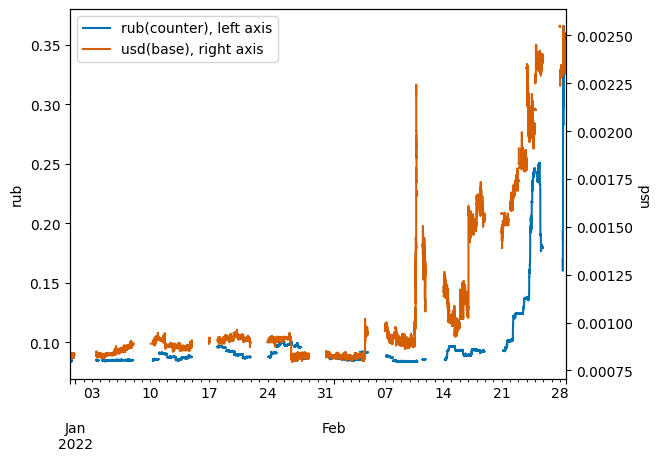

In [7]:
# interest rates data: 'rf' for the RUB rate, 'div_yield' for the USD rate.
d_rates = get_rates_data()
plot_rates(d_rates.set_index("date"))
plt.show()

## option contracts

FX options are quoted in terms of implied volatilities (henceforth "IV") of "at-the-money" contracts, as well as 10- and 25-delta "butterfly spreads" (aka "market strangles") and "risk reversals". The exact definitions of these differ between currency pairs, and I refer the reader to the excellent book ["Foreign Exchange Option Pricing: A Practitioner's Guide"](https://books.google.ch/books?id=7vua-0-2sgMC&redir_esc=y) by Iain Clark for further details. In what follows, `v_atm` references the at-the-money IV, `v_10b` (`v_25b`) &mdash; the IV of the 10-delta (25-delta) market strangle and `v_10r` (`v_25r`) &mdash; the IV of the 10-delta (25-delta) risk reversal.

In [8]:
# option contracts data
d_opt = get_option_contracts_data()

format_dataframe(d_opt.sort_values("date"), tail=True)

date,name,value
2022-02-28 16:44,v_10r,0.46
2022-02-28 16:44,v_25r,0.21
2022-02-28 16:44,v_atm,0.85
2022-02-28 16:44,v_25b,0.04
2022-02-28 16:44,v_10b,0.15


# methodology

## risk-neutral probability
To estimate the probability of the spot rate exceeding a certain threshold, I integrate the risk-neutral density of the spot rate extracted non-parametrically over a suitable domain.

The well-known result from [Breeden and Litzenberger (1978)](https://www.jstor.org/stable/2352653?seq=1#metadata_info_tab_contents) equates the risk-neutral density of the underlying $q(S)$ to the second derivative of the option pricing function $C(\cdot)$ w.r.t. the strike price $K$:
$$q(S) = e^{r_f \tau} \frac{\partial^2 C(S,K,\ldots)}{\partial K^2}.$$
With a pricing function at hand, numerical calculation of the density is straighforward. Here, I take $C$ to be the Black-Scholes pricing function at the level of SABR-derived implied volatilities along the strike dimension:
$$C(S, K), \ldots = C^{bs}(S, \hat{\sigma}(K), K, \ldots),$$
where $\hat{\sigma}(K)$ is the SABR volatility smile calibrated to the FX option contracts (details in the [data section](#data)).

## risk-neutral variance
tbd

# results

I present only the results of the calculations here. A detailed walkthrough is postponed to the [appendix](#walkthrough).

## risk-neutral probability <a name="prob"></a>

In [9]:
# non-parametric density, integrated from different levels upwards
fname = "output/estimates/prob-nonparam.csv"
prob = pd.read_csv(fname, index_col=0, parse_dates=True)\
    .rename(columns=int)

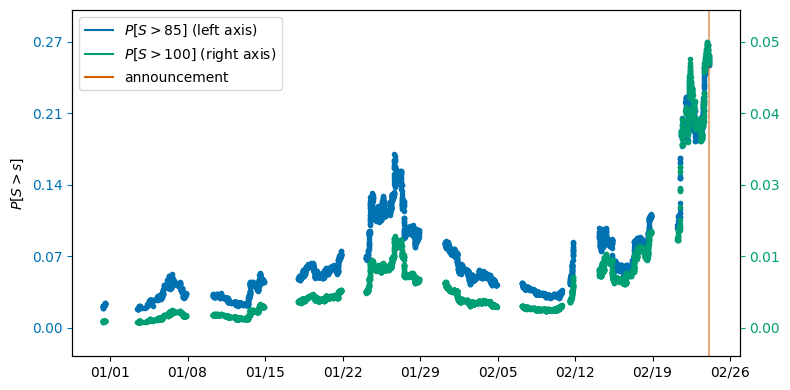

In [10]:
plot_invasion_probability(prob.loc[:dt_t], plot_warnings=False)
plt.show()

Next, I check how this probability changed in response to the forebodings of US officials. In total, there were 4 of them, as listed in the [data section](#events).

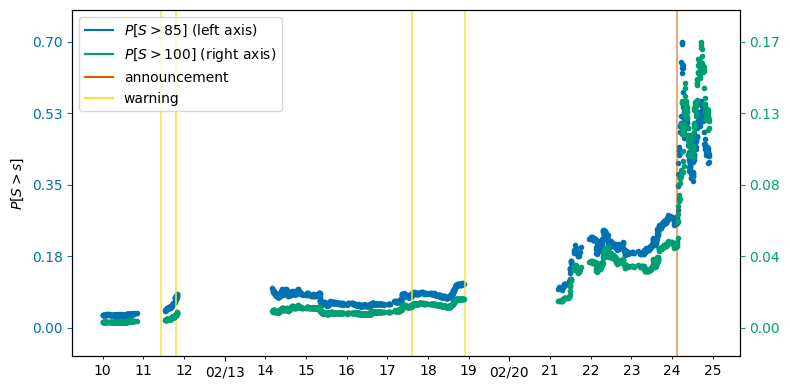

In [11]:
plot_invasion_probability(prob.loc["2022-02-10":"2022-02-24"], plot_warnings=True)
plt.show()

## risk-neutral variance of USDRUB <a name="mfiv"></a>

Finally, I estimate the forward-looking variance of USDRUB around the invasion using the standard result discussed i.a. in [Carr and Madan (2002)](http://pricing.online.fr/docs/TradingVolatilityStrat.pdf):

In [12]:
fname = "output/estimates/mfiv-nonparam.csv"
mfiv = pd.read_csv(fname, index_col=0, parse_dates=True)\
    .squeeze()

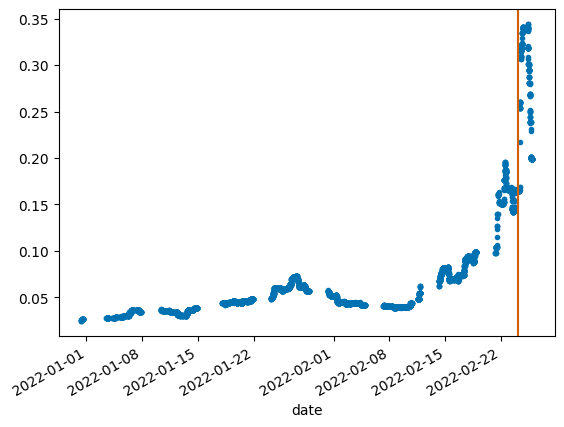

In [13]:
ax = mfiv.loc[:"2022-02-25"].plot(linestyle="none", marker=".")
ax.axvline(x=dt_t, color=palette[2])
plt.show()

Consistent with the previous results, the variance of the USDRUB returns went up over the course of a week before the invasion and further jumped up immediately after it.

# appendix

## walkthrough: <a name="walkthrough"></a>

In what follows I will walk an interested reader through the calculations. First, let's load the data, merge everything and select one datetime &mdash; the one right before the announcement.

In [14]:
# data
data = get_raw_data()\
    .pivot(index="date", columns="name", values="value")\
    .dropna()

# from discrete to continuous rates
data.loc[:, ["r_counter", "r_base"]] = \
    np.log(data[["r_counter", "r_base"]] + 1)

# select one little chunk (the last complete row before the invasion)
dt_t = get_timeline().index[0]
chunk = data.loc[:dt_t].iloc[[-1]]

format_dataframe(chunk)

date,forward,r_base,r_counter,spot,v_10b,v_10r,v_25b,v_25r,v_atm
2022-02-24 03:48,82.16,0.00,0.13,81.24,0.07,0.27,0.01,0.12,0.36


These values are sufficient to estimate the risk-neutral density. For that, as mentioned in the main part, the option pricing function is needed. I define it to be, for any strike $K$, the Black-Scholes formula evaluated at the implied volatility at that level of $K$; the volatility itself is a function of $K$, specifically, the fitted value of a SABR smile calibrated to the observed quotes of option contracts: 
$$C(S, K), \ldots = C^{bs}(S, \hat{\sigma}(K), K, \ldots).$$
The calibration process is tricky, as described in ch. 3.7.1 of [Clark (2011)](https://books.google.ch/books?id=7vua-0-2sgMC&redir_esc=y). Conventions such as at-the-money definition are taken from Bloomberg.

One thing to note is that the span of strike prices (implicitly) covered by the contracts is usually very narrow and does not extend into the interesting tail regions; this is yet another reason to take the estimates with a grain of salt.

Anyway, let's calibrate the SABR model to the chunk of data above:

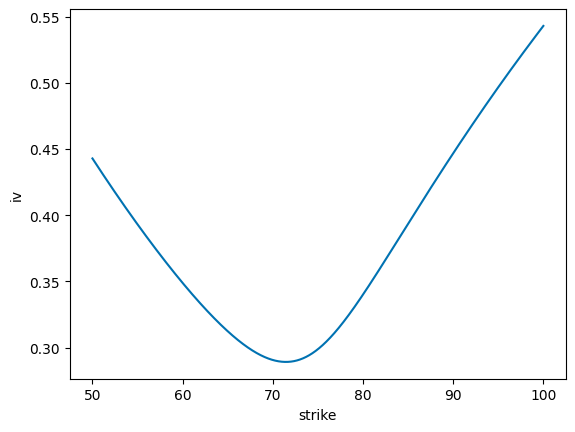

In [15]:
from optools.smile import SABR

# make Series for easier indexing
chunk = chunk.T.squeeze()

# fit
sabr = SABR.fit_to_fx(
    tau=TAU,
    v_atm=chunk["v_atm"],
    contracts={0.1: {"ms": chunk["v_10b"],
                     "rr": chunk["v_10r"]},
               0.25: {"ms": chunk["v_25b"],
                      "rr": chunk["v_25r"]}},
    delta_conventions={"atm_def": "dns",
                       "is_premiumadj": True,
                       "is_forward": False},
    **chunk[["spot", "forward", "r_counter", "r_base"]]
)

# plot
fig, ax = sabr.plot(domain=np.arange(50, 100, 1e-04))
ax.set_xlabel("strike")
ax.set_ylabel("iv")
plt.show()

`sabr` object above is a callable that computes the IV for a given $K$. Now, it is possible to define the option pricing function $C^{bs}(S, \hat{\sigma}(K), K, \ldots)$ as a function of $K$ only:

In [16]:
from optools.blackscholes import option_price as bs_price

sigma_hat = sabr  # enters the function below

def call_pricer(x_):
    """Get price of call option at a given strike.
    
    NB: takes global variable `data` defined above as input!
    """
    r_counter = chunk["r_counter"]
    
    # these are the same for any iloc in `data`
    forward = chunk["forward"]
    
    f = bs_price(strike=x_, vola=sigma_hat(x_), forward=forward,
                 r_counter=r_counter, tau=TAU, is_call=True)
    
    return f

# example
print(call_pricer(np.array([80, 90, 100.0])))

[4.32340218 1.54780975 0.70392301]


This function can be differentiated twice to arrive at the density. Below, I define a function to return the density at point `s`:

In [17]:
from scipy.misc import derivative

def density_estimator(s):
    """Get density at point `s`.
    
    Evaluates the second-order derivative of `call_pricer`.
    
    NB: takes global variables `call_pricer` and `data` defined above as input!
    
    """
    res = derivative(call_pricer, s, dx=1e-04, n=2) \
        * np.exp(chunk["r_counter"] * TAU)
    
    return res

# example
print(np.round(density_estimator(85.0), 4))

0.0336


Finally, to arrive at the probability of the spot rate exceeding a threshold, e.g. 85, at options' expiration, I integrate the density from this threshold to ~infinity~ a large value:

In [18]:
from scipy.integrate import simps

# domain of integration (step size of 1e-04)
thresh = 85.0
x = np.arange(thresh, 200, 1e-04)

# integrate
prob = simps(density_estimator(x), x)
print(np.round(prob, 4))

0.2607
